# Project 18 - Convolutional Neural Network to classify Homer or Bat Simpsons

In [7]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
import matplotlib.pyplot as plt
torch.__version__

'2.3.1+cu121'

In [4]:
path = 'Datasets/dataset_personagens.zip'

zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('Datasets/')
zip_obj.close()

In [5]:
data_dir_train = 'Datasets/dataset_personagens/training_set'
data_dir_test = 'Datasets/dataset_personagens/test_set'

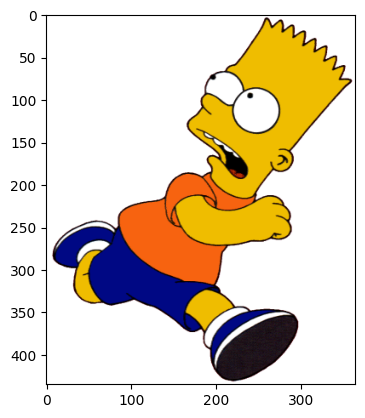

In [8]:
get_first_training_image = datasets.ImageFolder(data_dir_train)

plt.imshow(get_first_training_image[0][0])

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.activation1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.activation2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(in_features=14*14*32, out_features=4)
        self.activation3 = nn.ReLU()
        self.dense2 = nn.Linear(in_features=4, out_features=4)
        self.activation4 = nn.ReLU()
        self.output = nn.Linear(in_features=4, out_features=1)
        self.activation5 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.activation3(x)
        x = self.dense2(x)
        x = self.activation4(x)
        x = self.output(x)
        x = self.activation5(x)
        return x


model = Classifier()

In [22]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [23]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=7, translate=(0, 0.07),shear=0.2, scale=(1, 1.2)),
    transforms.ToTensor()
])

In [24]:
transform_test = transforms.Compose([
                                     transforms.Resize([64, 64]),
                                     transforms.ToTensor()
                                     ])

In [25]:
train_dataset = datasets.ImageFolder(data_dir_train, transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 10, shuffle = True)

In [26]:
test_dataset = datasets.ImageFolder(data_dir_test, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle = True)

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
model.to(device)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=6272, out_features=4, bias=True)
  (activation3): ReLU()
  (dense2): Linear(in_features=4, out_features=4, bias=True)
  (activation4): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
  (activation5): Sigmoid()
)

In [30]:
def training_loop(loader, epoch):
    running_loss = 0
    running_accuracy = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model.forward(inputs)

        loss = criterion(outputs, labels.float().view(*outputs.shape))
        running_loss += loss.item()
        loss.backward()

        optimizer.step()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        equals = predicted == labels.view(*predicted.shape)

        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

    print(f'Epoch {epoch} - Loss: {running_loss/len(loader)} - Accuracy: {running_accuracy/len(loader)}')


In [31]:
for epoch in range(100):
    print('Train...')
    training_loop(train_loader, epoch)

    model.eval()
    print('Test...')
    training_loop(train_loader, epoch)

    model.train()

Train...
Epoch 0 - Loss: 0.6713544815778733 - Accuracy: 0.6033333539962769
Test...
Epoch 0 - Loss: 0.671719241142273 - Accuracy: 0.596666693687439
Train...
Epoch 1 - Loss: 0.6705387502908706 - Accuracy: 0.6066666841506958
Test...
Epoch 1 - Loss: 0.6736017674207687 - Accuracy: 0.6000000834465027
Train...
Epoch 2 - Loss: 0.6705936014652252 - Accuracy: 0.606666624546051
Test...
Epoch 2 - Loss: 0.6719863504171372 - Accuracy: 0.6033333539962769
Train...
Epoch 3 - Loss: 0.6735532507300377 - Accuracy: 0.5999999642372131
Test...
Epoch 3 - Loss: 0.674929141998291 - Accuracy: 0.596666693687439
Train...
Epoch 4 - Loss: 0.6718237310647964 - Accuracy: 0.6033333539962769
Test...
Epoch 4 - Loss: 0.67035953104496 - Accuracy: 0.6066666841506958
Train...
Epoch 5 - Loss: 0.671774959564209 - Accuracy: 0.6033333539962769
Test...
Epoch 5 - Loss: 0.6718006938695907 - Accuracy: 0.6033332943916321
Train...
Epoch 6 - Loss: 0.6733902841806412 - Accuracy: 0.6000000238418579
Test...
Epoch 6 - Loss: 0.6732390671968

In [32]:
def classify_image(fname):
    from PIL import Image
    import matplotlib.pyplot as plt

    test_image = Image.open(data_dir_test + '/' + fname)
    plt.imshow(test_image)

    import numpy as np

    test_image = test_image.resize((64, 64))
    test_image = np.array(test_image.getdata()).reshape(*test_image.size, 3)
    test_image = test_image / 255

    test_image = test_image.transpose(2, 0, 1)
    test_image = torch.tensor(test_image, dtype=torch.float32).view(-1, *test_image.shape)

    model.eval()

    test_image = test_image.to(device)
    output = model.forward(test_image)

    if output > 0.5:
        output = 1
    else:
        output = 0
    
    print(f'Forecasting: {output} ')

    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

    return idx_to_class[output]

Forecasting: 0 


'bart'

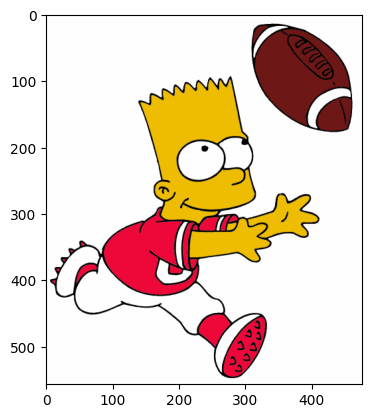

In [37]:
image = '/bart/bart18.bmp'
classify_image(image)

Forecasting: 0 


'bart'

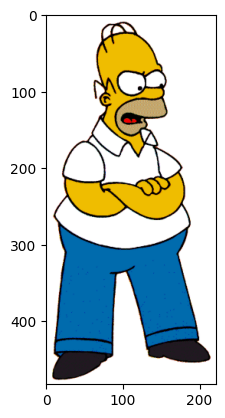

In [60]:
image = '/homer/homer30.bmp'
classify_image(image)